## Frame the Problem

This project addresses the critical business problem of identifying aircraft maintenance issues before they escalate into costly repairs or safety risks. Specifically, it focuses on analyzing sensor data to detect anomalies that may indicate a damaged or leaking intake gasket and loose, leaking, or damaged rocker covers. Such issues can lead to oil leaks, contamination of engine components, loss of lubrication, and potentially, engine failure. By implementing a machine learning-based anomaly detection system, this project aims to identify these problems early, enabling proactive preventative maintenance to reduce costs and enhance safety. The analysis will utilize data from the National General Aviation Flight Information Database (NGAFID) to explore multivariate time series sensor data.

To achieve this goal, this project will employ a variety of machine learning techniques. Unsupervised methods, such as clustering algorithms (K-means and DBSCAN) and dimensionality reduction techniques (PCA), will help uncover patterns that deviate from normal behavior. Supervised learning models, including logistic regression, random forests, and neural networks, will classify abnormal behavior when labeled data is available. Semi-supervised approaches will leverage labeled normal data alongside abundant unlabeled data to train anomaly detectors, such as one-class SVMs and isolation forests, particularly in cases where it is unclear which data points are normal or anomalous. Time-series-specific methods, such as RNNs, LSTMs, and ARIMA, will model temporal dependencies in the sensor data to detect deviations over time. In the absence of detailed knowledge about the system's mechanics, this project will adopt a hybrid approach that integrates these techniques to analyze historical flight sensor data, identify patterns, and detect anomalies, to ultimately facilitate effective preventative aviation maintenance.

## Setup

In [ ]:
# Follow instructions for downloading datasets via kagglehub - https://www.kaggle.com/docs/api#getting-started-installation-&-authentication
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d hooong/ngafid-mc-20210917
# !unzip ngafid-mc-20210917.zip

In [ ]:
#!python -m pip install -q kaggle kagglehub colored umap-learn plotly statsmodels

In [ ]:
#!pip install --upgrade kagglehub

### Imports

In [1]:
import kagglehub
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import os
from glob import glob
from colored import Fore, Style
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm
import umap
from umap import UMAP
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    QuantileTransformer,
)
from typing import Union

In [3]:
# Support running local and running in google colab
local_mode = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    local_mode = True
print(f'Local Mode: {local_mode}')

Local Mode: True


### Configurations

In [5]:
pd.set_option('display.max_rows', 100)

In [7]:
sns.set_style('darkgrid')

### NGAFID-MC Dataset
Implementation paper reference: https://arxiv.org/pdf/2110.03757

### Data Dictionary

| **Column**   | **Description**                                                                      | **Example** | **Unit of Measure**          |
|--------------|--------------------------------------------------------------------------------------|-------------|------------------------------|
| volt1        | Main electrical system bus voltage (alternators and main battery)                    | 28.1        | Volts (V)                    |
| volt2        | Essential bus (standby battery) bus voltage                                          | 28.1        | Volts (V)                    |
| amp1         | Ammeter on the main battery (+ charging, - discharging)                              | 6.4         | Amperes (A)                  |
| amp2         | Ammeter on the standby battery (+ charging, - discharging)                           | 0.4         | Amperes (A)                  |
| FQtyL        | Fuel quantity left                                                                   | 20.22       | Gallons (gal)                |
| FQtyR        | Fuel quantity right                                                                  | 23.84       | Gallons (gal)                |
| E1 FFlow     | Engine fuel flow rate                                                                | 2.54        | Gallons/hour (gal/hr)        |
| E1 OilT      | Engine oil temperature                                                               | 74.25       | Degrees Celsius (°C)         |
| E1 OilP      | Engine oil pressure                                                                  | 67.5        | Pounds per square inch (psi) |
| E1 RPM       | Engine rotations per minute                                                          | 1229        | Rotations per minute (rpm)   |
| E1 CHT1      | 1st cylinder head temperature                                                        | 84.6        | Degrees Celsius (°C)         |
| E1 CHT2      | 2nd cylinder head temperature                                                        | 86.9        | Degrees Celsius (°C)         |
| E1 CHT3      | 3rd cylinder head temperature                                                        | 86.44       | Degrees Celsius (°C)         |
| E1 CHT4      | 4th cylinder head temperature                                                        | 81.94       | Degrees Celsius (°C)         |
| E1 EGT1      | 1st Exhaust gas temperature                                                          | 1108        | Degrees Celsius (°C)         |
| E1 EGT2      | 2nd Exhaust gas temperature                                                          | 1006        | Degrees Celsius (°C)         |
| E1 EGT3      | 3rd Exhaust gas temperature                                                          | 1022        | Degrees Celsius (°C)         |
| E1 EGT4      | 4th Exhaust gas temperature                                                          | 1035        | Degrees Celsius (°C)         |
| OAT          | Outside air temperature                                                              | -2.2        | Degrees Celsius (°C)         |
| IAS          | Indicated air speed                                                                  | 0           | Knots (kt)                   |
| VSpd         | Vertical speed                                                                       | 13.21       | Feet per second (ft/s)       |
| NormAc       | Normal acceleration                                                                  | -0.03       | G-Force (g)                  |
| AltMSL       | Altitude miles above sea level                                                       | 838         | Feet (ft)                    |
| id           | Unique row identifier                                                                | 0           | None (identifier)            |
| plane_id     | Unique plane identifier                                                              | 37          | None (identifier)            |
| split        | Dataset split number                                                                 | 0           | None (identifier)            |
| date_diff    | Date difference                                                                      | 1           | Days                         |
| before_after | Whether the record represents before or after respective maintenance event (target). | 0           | Binary (0 or 1)              |


NGAFID-MC has two separate clusters. This is because some maintenance issues occurred very rarely. The NGAFID-MC dataset focuses on the two largest clusters, C28 and C37.
* **Cluster 28 (C28)**: Intake gasket leak/damage.
* **Cluster 37 (C37)**: Rocker cover loose/leak/damage.

In [9]:
# Download data if running in local mode (not in colab notebook)
data_dir = './'
if local_mode:
    # Download latest version
    data_dir = kagglehub.dataset_download("hooong/ngafid-mc-20210917")
    cluster_paths = glob(os.path.join(data_dir, '*.csv'))
    c28_path, c37_path = cluster_paths
else:
    data_dir = '/content/drive/MyDrive/ColabNotebooks/'
    c28_path = os.path.join(data_dir, 'NGAFID_MC_C28.csv')
    c37_path = os.path.join(data_dir, 'NGAFID_MC_C37.csv')
print("Path to dataset files:", data_dir)

Path to dataset files: C:\Users\Brett\.cache\kagglehub\datasets\hooong\ngafid-mc-20210917\versions\1


In [12]:
assert c28_path.lower().endswith('c28.csv'), f'{Fore.red}Unit test failed.{Style.reset}'
print(f'{Fore.green}Unit test passed.\nc28_path = "{c28_path}"{Style.reset}')

Unit test passed.
c28_path = "C:\Users\Brett\.cache\kagglehub\datasets\hooong\ngafid-mc-20210917\versions\1\NGAFID_MC_C28.csv"


In [14]:
assert c37_path.lower().endswith('c37.csv'), f'{Fore.red}Unit test failed.{Style.reset}'
print(f'{Fore.green}Unit test passed.\nc37_path = "{c37_path}"{Style.reset}')

Unit test passed.
c37_path = "C:\Users\Brett\.cache\kagglehub\datasets\hooong\ngafid-mc-20210917\versions\1\NGAFID_MC_C37.csv"


### Load the Data

In [17]:
c28_df = pd.read_csv(c28_path)
c28_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split,date_diff,before_after
0,28.1,28.1,6.4,0.4,20.22,23.84,2.54,74.25,67.50,1229.0,...,-2.2,0.0,13.21,-0.03,838.0,0,37,0,1,0
1,28.1,28.1,6.4,0.4,20.22,23.84,2.54,74.25,67.50,1229.0,...,-2.2,0.0,13.21,-0.03,838.0,0,37,0,1,0
2,28.1,28.1,6.4,0.5,20.27,23.84,2.47,74.25,67.44,1226.0,...,-2.2,0.0,11.15,-0.03,839.0,0,37,0,1,0
3,28.1,28.1,6.3,0.4,20.22,23.89,2.40,74.25,67.44,1228.0,...,-2.2,0.0,0.65,0.02,NaN,0,37,0,1,0
4,28.1,28.1,6.2,0.4,20.22,23.84,2.38,74.25,67.50,1230.0,...,-2.5,0.0,-22.52,-0.02,841.0,0,37,0,1,0


In [11]:
c37_df = pd.read_csv(c37_path)
c37_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split,date_diff,before_after
0,27.9,27.9,7.9,0.7,24.0,24.0,2.09,129.2,61.16,1191.0,...,7.2,0.0,15.74,-0.02,822.5,2,18,4,-2,1
1,27.9,27.9,7.9,0.6,24.0,24.0,2.13,129.2,61.20,1192.0,...,7.2,0.0,11.13,-0.00,822.5,2,18,4,-2,1
2,27.9,28.0,8.0,0.6,24.0,24.0,2.07,129.2,61.03,1186.0,...,7.2,0.0,-0.85,0.00,NaN,2,18,4,-2,1
3,27.9,27.9,7.8,0.6,24.0,24.0,2.12,129.2,61.16,1190.0,...,7.2,0.0,-30.64,-0.03,824.5,2,18,4,-2,1
4,27.9,27.9,7.7,0.6,24.0,24.0,2.08,129.1,61.25,1197.0,...,7.2,0.0,-23.95,-0.02,825.0,2,18,4,-2,1


In [25]:
# CHeck headers from both C37 and C28
print(c37_df.columns)
print(c28_df.columns)

Index(['volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow',
       'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3',
       'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS',
       'VSpd', 'NormAc', 'AltMSL', 'id', 'plane_id', 'split', 'date_diff',
       'before_after'],
      dtype='object')
Index(['volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow',
       'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3',
       'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS',
       'VSpd', 'NormAc', 'AltMSL', 'id', 'plane_id', 'split', 'date_diff',
       'before_after'],
      dtype='object')


**Observation:**
* C28 and C37 both use the same header names.

## EDA

In [27]:
def get_missing_values(df: [pd.DataFrame]) -> pd.DataFrame:
    """
    Create a dataframe to represent the missing values in the original dataframe.

    Args:
        df: Original dataframe to identify missing values.

    Returns:
        New dataframe representing a report of missing values in original dataframe.
    """
    df_len = len(df)
    total_missing = df.isna().sum()
    total_available = df_len - total_missing
    ratio_missing = total_missing / df_len
    percent_missing = ratio_missing*100
    mapped_percent_missing = None
    if isinstance(df, pd.DataFrame):
        mapped_percent_missing = percent_missing.map(lambda p: f'{p:.1f}%')
    else:
        mapped_percent_missing = percent_missing.map(lambda p: f'{p:.1f}%', meta=(None, 'object'))

    return pd.DataFrame({
        'total_missing': total_missing,
        'total_available': total_available,
        'ratio_missing': ratio_missing,
        'percent_missing': mapped_percent_missing,
    }, index=df.columns)

### Evaluation of Cluster 28 (C28)
Maintenance Issue: **Intake gasket leak/damage**

In [29]:
c28_len = len(c28_df)
c28_n_cols = len(c28_df.columns)
c28_len, c28_n_cols

(28783265, 28)

In [31]:
print(f'There are {c28_len:,} records and {c28_n_cols:,} columns in the C28 cluster, representing intake gasket leak/damage maintenance issue.')

There are 28,783,265 records and 28 columns in the C28 cluster, representing intake gasket leak/damage maintenance issue.


In [33]:
c28_df.head(1).T

,0
volt1,28.10
volt2,28.10
amp1,6.40
amp2,0.40
FQtyL,20.22
FQtyR,23.84
E1 FFlow,2.54
E1 OilT,74.25
E1 OilP,67.50
E1 RPM,1229.00


In [39]:
# Analyze spread of unique planes (aircraft) by id for cluster 28
# NOTE: compute() returns a pandas object (e.g., pd.DataFrame, pd.Series)
c28_plane_counts = c28_df['plane_id'].value_counts()

In [41]:
c28_plane_counts.sort_index()

plane_id
0     132163
1     461617
2     535723
3     142415
4     270691
5     435396
6     398771
7     463871
8     430894
9     246981
10    196966
11    621966
12    117591
13    631542
14    363483
15    495495
16    616249
17    473757
18    572905
19    196104
20    267393
21    830435
22    310355
23     99895
24     31925
25    785933
26    879600
27    266358
28    336463
29    266876
30    116332
31    211245
32    270069
33    312747
34    656836
35    340840
36    610014
37    454371
38      8492
39    567991
40    667113
41    528366
42    367791
43    639185
44    190039
45    154741
46    557363
47    478650
48    687109
49    466426
50    187382
51    544093
52    169296
53    944065
54    342165
55    436785
56    211227
57    624604
58    665835
59    856867
60     88676
61    381660
62    202181
63     26667
64     42704
65    279513
66    378489
67    195047
68     55468
69    269481
70    420233
71    267495
72    284289
73    179534
74    306930
75     53084
76 

In [43]:
# Compute the average count
c28_plane_counts.mean()

369016.21794871794

**Observation:** `78` unique plane IDs with an average number of points per flight greater than 100k

#### Analyzing Missing Values

In [45]:
get_missing_values(c28_df)

,total_missing,total_available,ratio_missing,percent_missing
volt1,2357,28780908,0.000082,0.0%
volt2,1986719,26796546,0.069023,6.9%
amp1,3646,28779619,0.000127,0.0%
amp2,1986857,26796408,0.069028,6.9%
FQtyL,4969,28778296,0.000173,0.0%
FQtyR,2513,28780752,0.000087,0.0%
E1 FFlow,2798,28780467,0.000097,0.0%
E1 OilT,2939,28780326,0.000102,0.0%
E1 OilP,3034,28780231,0.000105,0.0%
E1 RPM,3052,28780213,0.000106,0.0%


**Observation**: There is a good chunk of missing values missing for certain features. However, relative to the total number of records, the missing values represent a small percentage of the dataset, with `6.9%` missing values being the greatest (e.g., for `volt2`, `amp2`, `E1 CHT2`, `E1 CHT3`, and `E1 CHT4`).

To determine the best approach in terms of imputation or dropping records with nulls, we need to analyze the distribution for each of the features first. If the feature is normally distributed, we can impute with the mean value for that features. Otherwise, if the feature is skewed or random, we can impute with the median value.

### Evaluation of Cluster 37 (C37)
Maintenance Issue: **Rocker cover loose/leak/damage**

In [21]:
c37_len = len(c37_df)
c37_n_cols = len(c37_df.columns)
c37_len, c37_n_cols

(13414567, 28)

In [49]:
print(f'There are {c37_len:,} records and {c37_n_cols:,} columns in the C37 cluster, which represents rocker cover loose/leak/damage maintenance issue.')

There are 13,414,567 records and 28 columns in the C37 cluster, which represents rocker cover loose/leak/damage maintenance issue.


##### Analyzing Missing Values

In [52]:
get_missing_values(c37_df)

,total_missing,total_available,ratio_missing,percent_missing
volt1,914,13413653,0.000068,0.0%
volt2,137374,13277193,0.010241,1.0%
amp1,977,13413590,0.000073,0.0%
amp2,137443,13277124,0.010246,1.0%
FQtyL,5007,13409560,0.000373,0.0%
FQtyR,962,13413605,0.000072,0.0%
E1 FFlow,1114,13413453,0.000083,0.0%
E1 OilT,1182,13413385,0.000088,0.0%
E1 OilP,1240,13413327,0.000092,0.0%
E1 RPM,1244,13413323,0.000093,0.0%


**Observation**: The C37 cluster is more clean than the C28 cluster. There are fewer null values with the same features missing `1.0%` of the total values rather than `6.9%`.
* `volt2`
* `amp2`
* `E1 CHT2`
* `E1 CHT3`
* `E1 CHT4`

In [55]:
# Analyze spread of unique planes (aircraft) by id for cluster 37
c37_plan_counts = c37_df['plane_id'].value_counts()
c37_plan_counts.sort_index()

plane_id
0     154443
1     247891
2     144323
3     201771
4     291199
5     255585
6     439746
7     191388
8     313389
9     137716
10    260899
11    227925
12    388815
13    251949
14    165740
15    339100
16    164865
17    370935
18    117977
19    240597
20    303279
21     98418
22    204219
23     97091
24    141808
25     92304
26    117590
27    233188
28    283113
29    103806
30     99680
31    316067
32    242729
33     56299
34    181045
35    226082
36    259717
37    100962
38     35879
39    164010
40    264474
41    249045
42     89613
43    107047
44    302265
45    267032
46    362436
47    157487
48    134612
49    189803
50     90700
51    268500
52     40413
53    169514
54    171060
55    233733
56    247726
57    250690
58    165743
59    157638
60    103810
61    333891
62    137075
63     59098
64    108013
65     52832
66    100072
67    128866
68     23240
69     48073
70     40190
71     29747
72     20094
73     19216
74     27280
Name: count, dty

In [57]:
# Compute the average count
c37_plan_counts.mean()

178860.89333333334

**Observation:** `75` unique plane IDs in the C37 cluster, also averaging more than 100k per plan.

### Insights & Visualizations
Given the size of the datasets, lets proceed with EDA insights and visualizations on only the C37 cluster (rocker cover loose/leak/damage) since it is more clean and has fewer records than the C28 cluster.

#### Analysis of Seasonality

In [61]:
# Analyze variance for date diff
c37_df['date_diff'].var()

2.0782152686458866

In [63]:
# Analyze number of records per date diff
c37_df['date_diff'].value_counts()

date_diff
 1    5786818
-1    2653772
-2    2650483
 2    2323494
Name: count, dtype: int64

In [65]:
# Analyze spread of labels by date diff
c37_df.groupby(['date_diff', 'before_after']).size()

date_diff  before_after
-2         1               2650483
-1         1               2653772
 1         0               5786818
 2         0               2323494
dtype: int64

**Observation:** Unfortunately, this dataset does not contain an actual datetime feature that we can analyze seasonality with. However, based on analysis of the `date_diff` and `before_after`, we can see that `before_after` is only `1` when `date_diff` is `-1` or `-2` (less than 0) and is only `0` when `date_diff` is `1` or `2` (greater than 0).

In [67]:
# Analyze class imbalance
c37_label_counts = c37_df['before_after'].value_counts()
pd.DataFrame({
    'count': c37_label_counts,
    'N': c37_len,
    'ratio': c37_label_counts / c37_len
}).sort_index()

,count,N,ratio
before_after,,,
0,8110312,13414567,0.60459
1,5304255,13414567,0.39541


**Observation:** There appears to be a class imbalance, favoring the negative class as majority at approximately `60%` over the positive class at approximately `40%`. 

**Null Values Heatmap**
Visualizing the spread of null values through this large dataset.

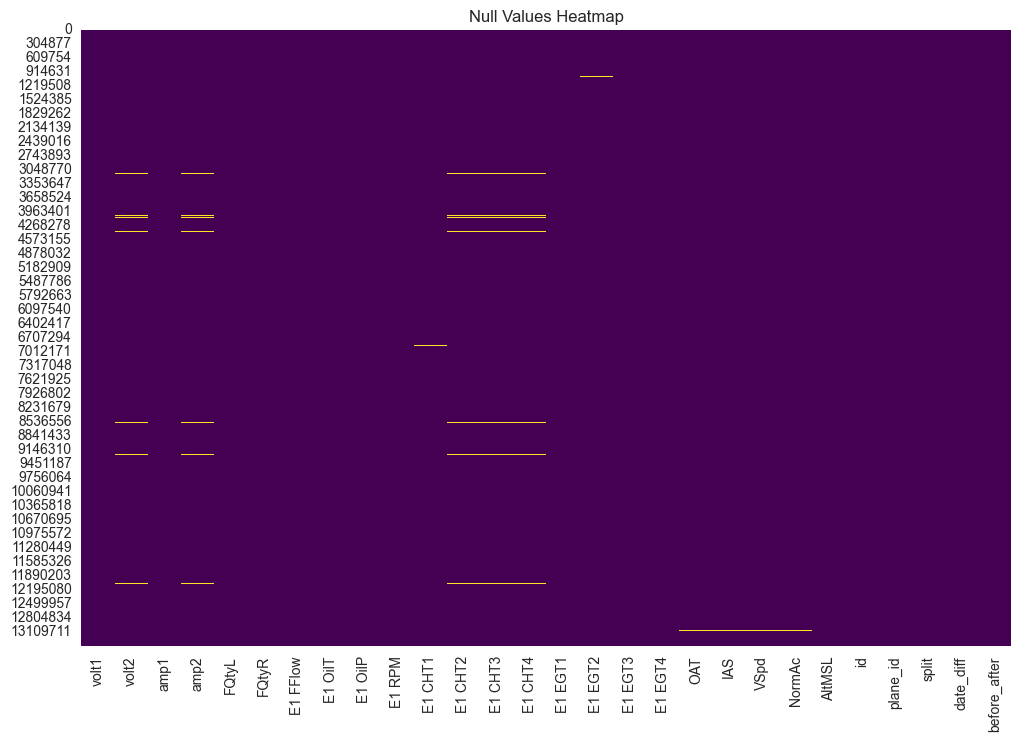

In [70]:
# Create a heatmap to visualize nulls
# Color map catalog: https://cmap-docs.readthedocs.io/en/latest/catalog/
plt.figure(figsize=(12, 8))
sns.heatmap(c37_df.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values Heatmap')
plt.show()

**Observation:** Null values are spread relatively randomly across the dataset. We can either impute these values by forward filling them with the previous non-null value, or we can leave them as is. Tree-based models such as XGBoost are not affected by null values so leaving the null values will not be detrimental to model training.

#### Univariate Analysis

In [72]:
def generate_histplots(data: pd.DataFrame, ncols: int=4, bins=20, title: str='Distribution per Feature', figsize: tuple=(20, 15), **kwargs):
    """
    Generate histogram plots for dataset to analyze distribution of the data.

    Args:
        data (pd.DataFrame): Dataset to generate histogram plots for.
        ncols (int, optional): Number of column in the produced figure. Defaults to 4.
        bins (int, optional): Number of bins for each histogram plot. Defaults to 20.
        title (str, optional): Title of the figure. Defaults to 'Histogram Plots'.
        figsize (tuple, optional): Size of the figure. Defaults to (20, 15).
    """
    if data is None or data.empty:
        return

    # Dynamically determine number of columns and rows for subplots
    ncols = min(ncols, len(data.columns))
    nrows = (len(data.columns) + ncols - 1) // ncols

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Flatten 2D axes array to 1D
    if max(nrows, ncols) > 1:
        axes = axes.ravel()
    else:
        axes = np.array([axes])

    for i, col in enumerate(data.columns):
        sns.histplot(data=data[col], ax=axes[i], bins=bins, **kwargs)
        axes[i].set_title(col)
        axes[i].set(xticklabels=[], xticks=[])

    # Remove unused plots
    for i in range(len(data.columns), nrows * ncols):
        fig.delaxes(axes[i])

    if title:
        fig.suptitle(title, weight='bold')

    plt.tight_layout()
    plt.show()

**Feature Histograms**
Visualizing each feature to identify how the dataset is distributed.

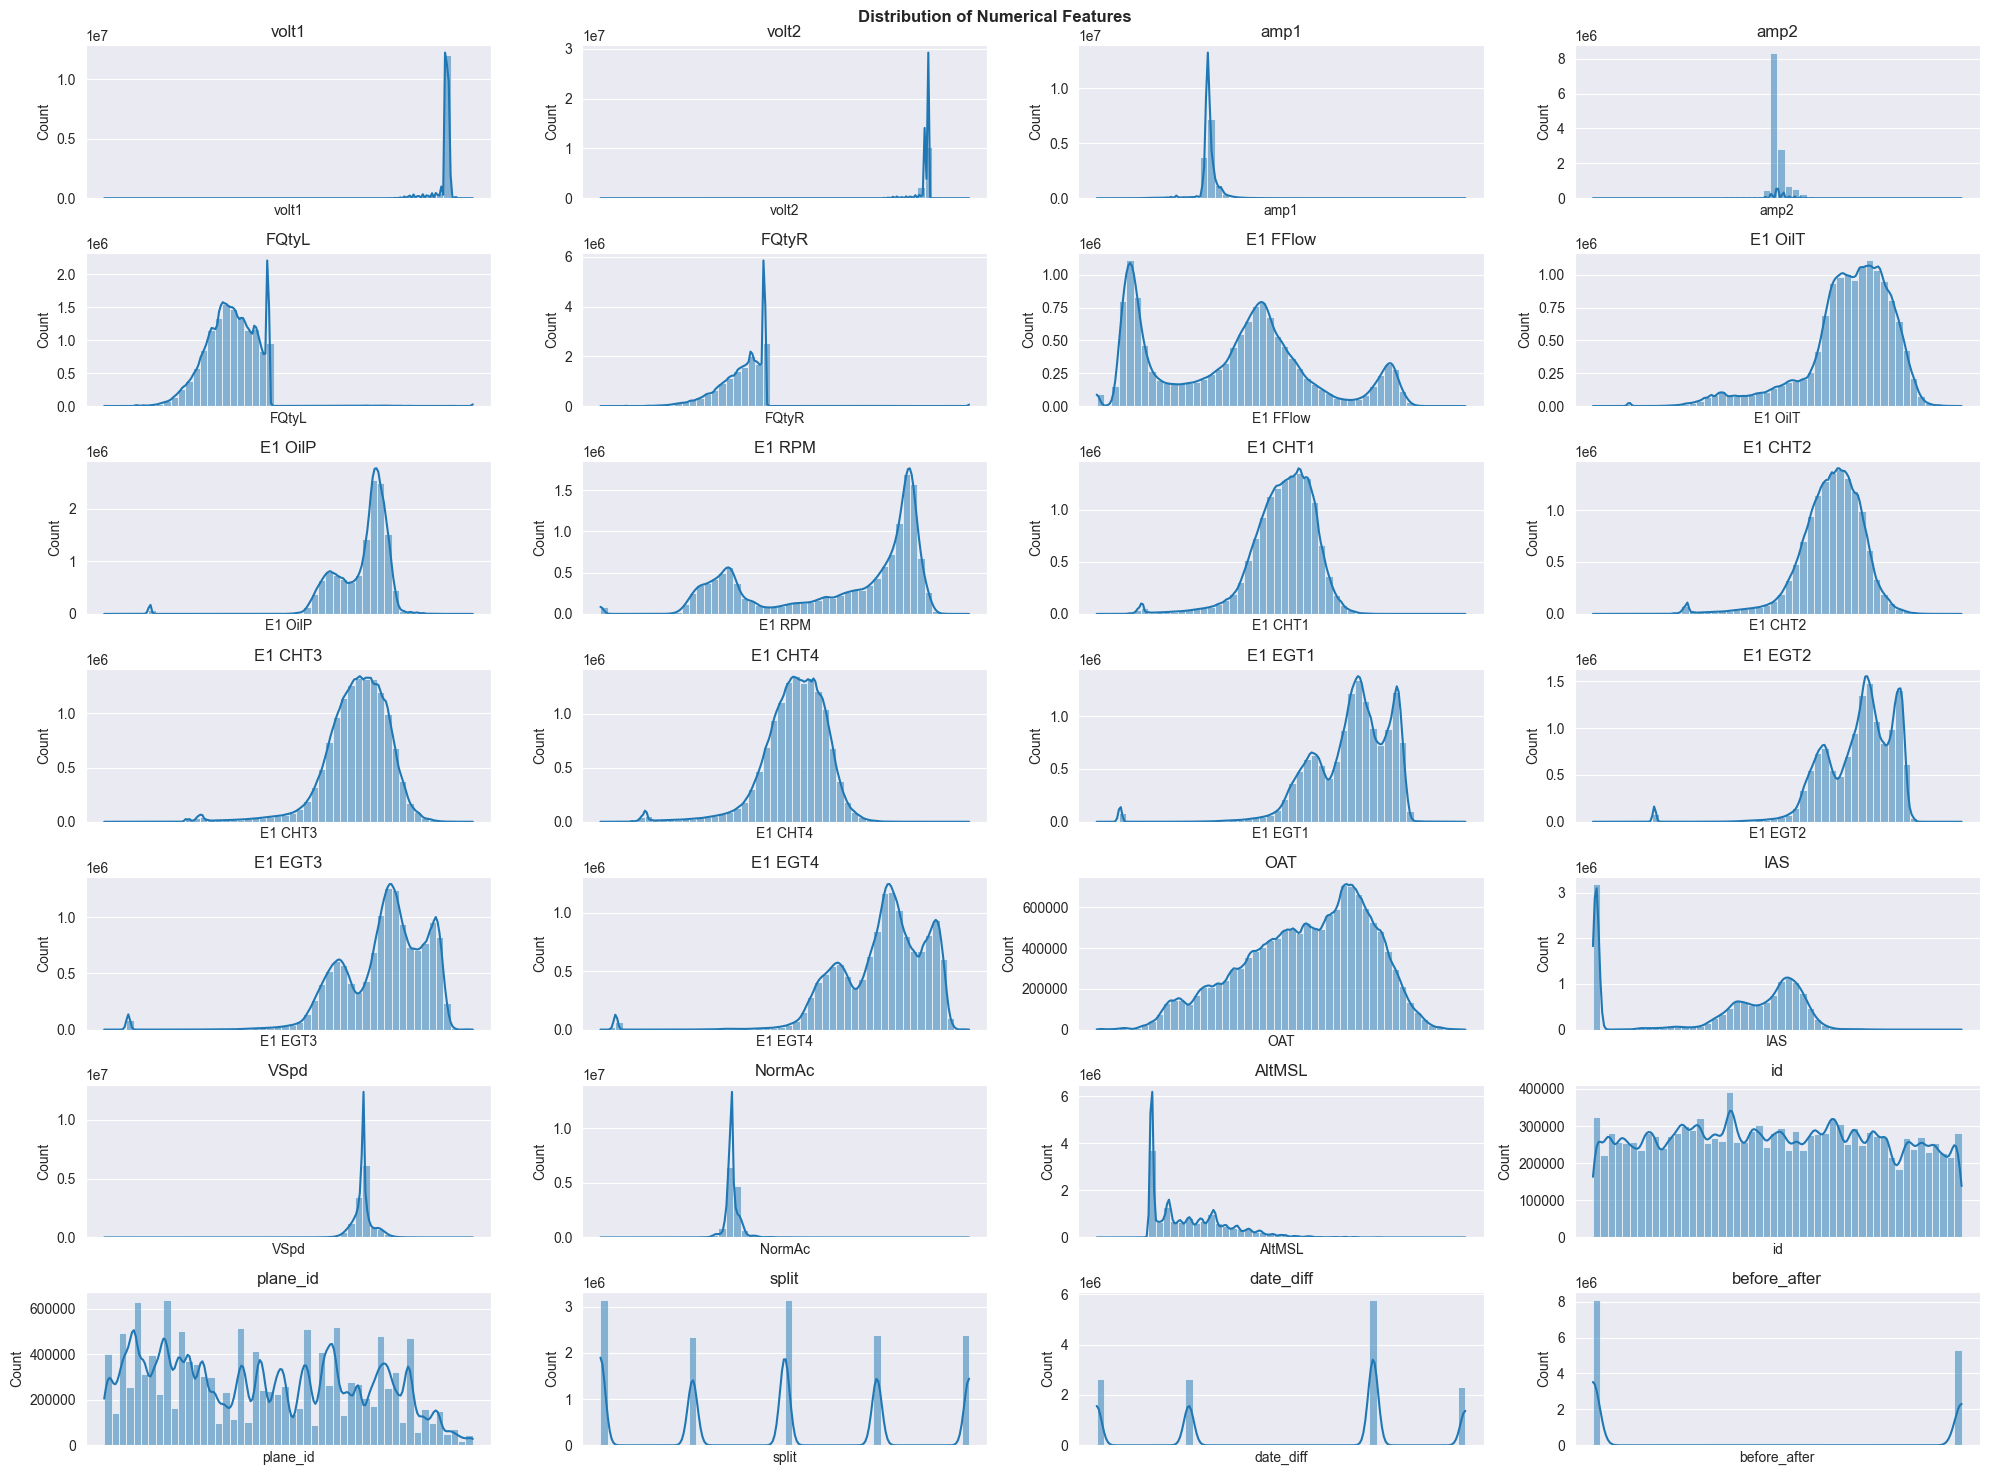

In [74]:
# Analyze each feature to determine whether they are normally distributed or not.
generate_histplots(c37_df, kde=True, bins=50, title='Distribution of Numerical Features')

**Observation:**

* **Skewed Distributions**: Many variables exhibit right-skewed distributions, indicating a concentration of data points towards lower values and a few extreme outliers. This is particularly noticeable in variables like FQtyL, FQtyR, and E1 RPM.

* **Outliers**: Several variables show potential outliers, such as volt1, volt2, and E1 EGT1. These outliers could be due to measurement errors or unusual flight conditions and might require further investigation or handling during model building.

* **Normal-like Distributions**: Some variables, like amp1, amp2, and E1 CHT2, appear to have more normally distributed values, suggesting that their values are spread more evenly across the range.

* **Narrow Range**: Variables like split, date_diff, and before_after have a limited range of values, indicating that they might not be as informative for predicting the target variable.

Overall, the distributions highlight the need for careful data cleaning and preprocessing to handle outliers and potential data transformations to normalize skewed distributions.

**Feature Histograms**
without outliers.

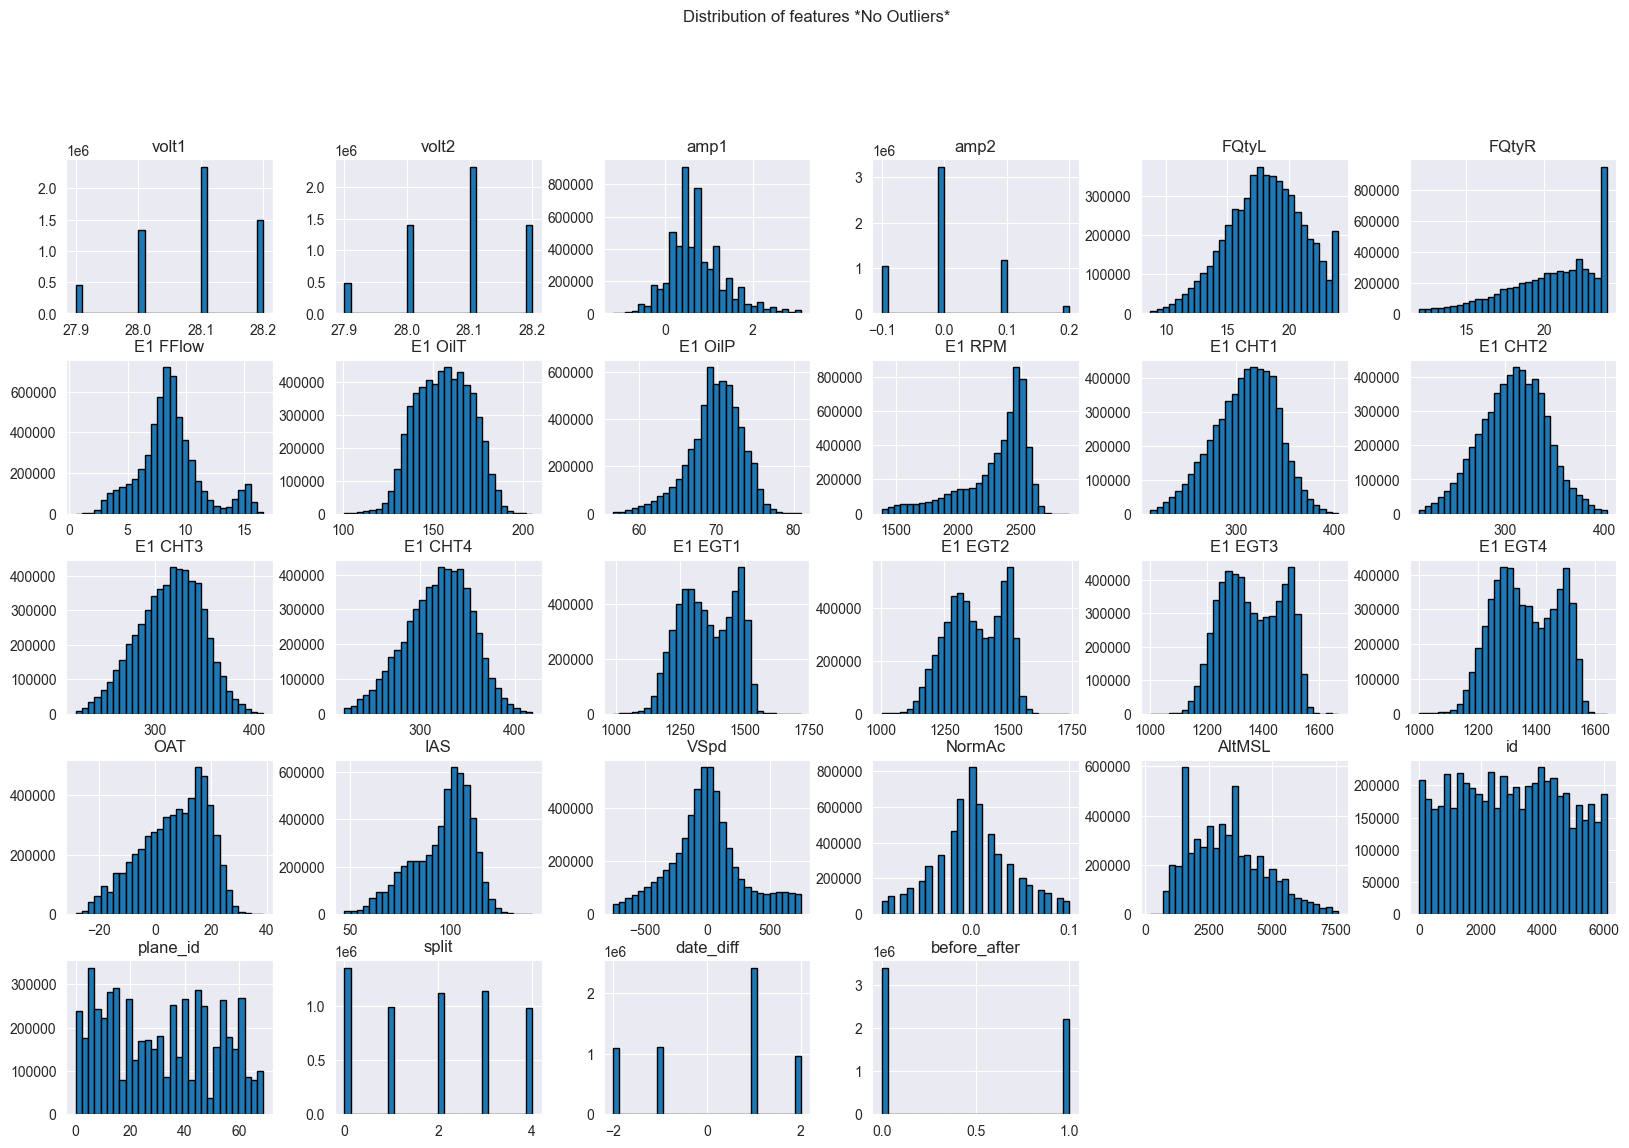

In [76]:
# Using Pandas DF for feature distribution
#c37_pd_df = pd.read_csv(c37_path)
#c37_pd_df.head()

# IQR threshold of 1.5 used for outlier detection
def remove_outliers(data, columns):
    for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lowerQ = Q1 - 1.5 * IQR
            upperQ = Q3 + 1.5 * IQR
            data = data[(data[col] >= lowerQ) & (data[col] <= upperQ)]
    return data

# Create dataframe for excluding the outliers
without_outliers = remove_outliers(c37_df, c37_df.columns)

# Show distribution of features without outliers
without_outliers.hist(bins = 30, figsize = (20, 15), layout = (6, 6), edgecolor = 'black')
plt.suptitle('Distribution of features *No Outliers*')
plt.show()

**Box Plots** Visualizing the numerical features in box plots to identify any outliers.

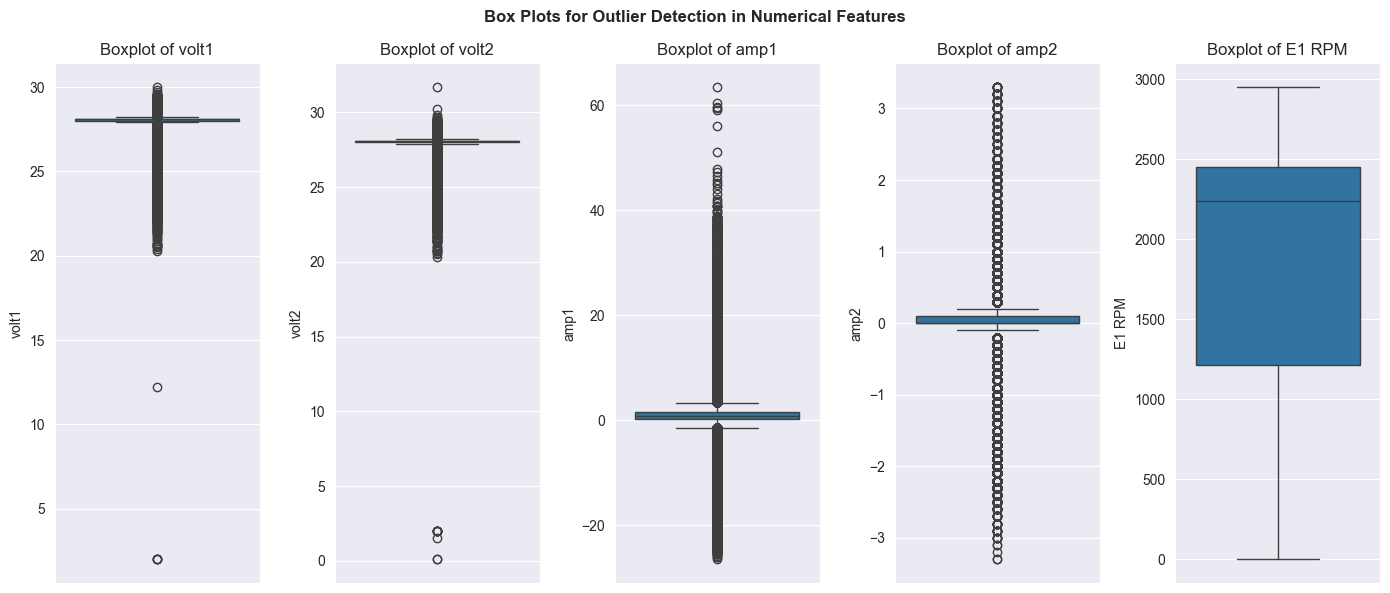

In [78]:
# Outlier Detection: Using Box plots to detect outliers in the numerical features.
# List of columns to plot
cols = ['volt1', 'volt2', 'amp1', 'amp2', 'E1 RPM']

fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(14, 6))

# Flatten axes for easier traversal
axes = axes.ravel()

# Loop through columns and create a subplot for each
for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(data=c37_df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')

plt.xticks(rotation=45)
fig.suptitle('Box Plots for Outlier Detection in Numerical Features', weight='bold')
plt.tight_layout()
plt.show()

**Observation:**
* **Outliers**: volt1, volt2, amp1, and amp2 have outliers, indicating unusual values.

* **Tight Distribution**: volt1 and volt2 have a tight distribution, suggesting consistent values.

* **Skewed Distribution**: amp1 and amp2 are slightly skewed, with more values on the lower end.

* **Wide Range**: E1 RPM has a wide range of values, indicating variability.

**Pie Chart of Before Maintenance and After Maintenance**
Visualizing how much data is generated before and after maintanence is performed to determine if there is a distinct change in the time series data for particular features.  

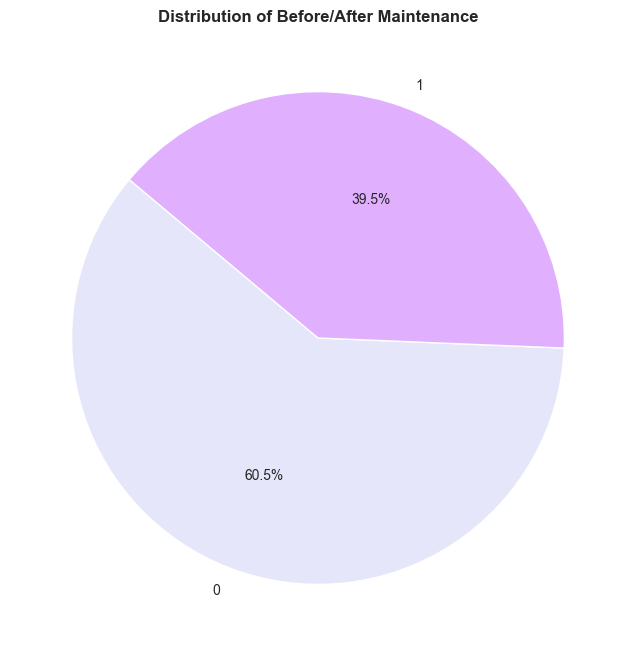

In [80]:
# Pie chart for the distribution of the target variable 'before_after'
plt.figure(figsize=(8, 8))
c37_df['before_after'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors= ['#E6E6FA', '#E0B0FF'], )
plt.title('Distribution of Before/After Maintenance', weight='bold')
plt.ylabel('')
plt.show()

**Observation:**

* **Data Imbalance**: The dataset is imbalanced, with approximately 60.5% of the data representing the "before maintenance" condition and 39.5% representing the "after maintenance" condition.

* **Class Distribution**: There's a significant difference in the number of samples for each class, which might impact the model's performance. The imbalance suggests that there are more records related to the system's condition before maintenance than after. This could indicate that maintenance events are relatively rare compared to the frequency of recorded operational issues.More focus in the dataset is placed on diagnosing pre-maintenance failures.

* **Potential Impact:** This imbalance might influence predictive maintenance models, potentially skewing the model toward "before" conditions if not addressed. Techniques like resampling (oversampling or undersampling) or class weighting might be necessary to ensure balanced predictions.

**The class imbalance should be considered during model training and evaluation to ensure fair and accurate predictions.**

#### Bivariate Analysis

**Scatterplot of volt1 and E1 RPM**
Visualizing the volt1 and E1 RPM data to determine if there is a correlation between these two features.

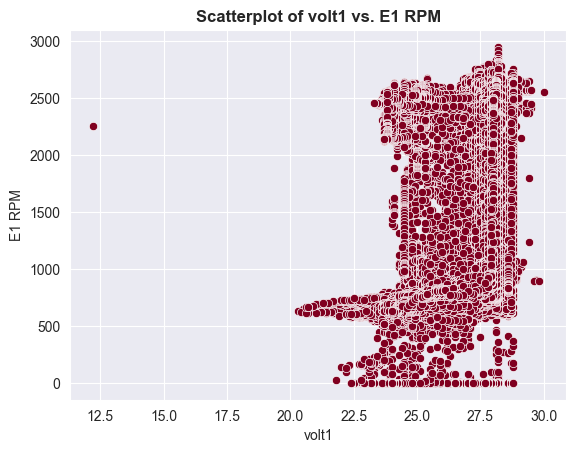

In [85]:
# Scatterplot between two numerical variables
sns.scatterplot(x='volt1', y='E1 RPM', data=c37_df,color='#800020' )
plt.title('Scatterplot of volt1 vs. E1 RPM', weight='bold')
plt.show()

**Observation:**

* **Weak Positive Correlation**: There's a slight positive relationship between the main electrical system bus voltage (volt1) and engine RPM (E1 RPM).

* **Clustering**: Data points cluster in specific regions, indicating potential operational modes or engine load conditions.

* **Outliers**: A few outliers suggest unusual operating conditions or measurement errors.

**Pairplots**
An ensemble of visualizations for features to identify any possible correlations (or outliers, etc.) between features.

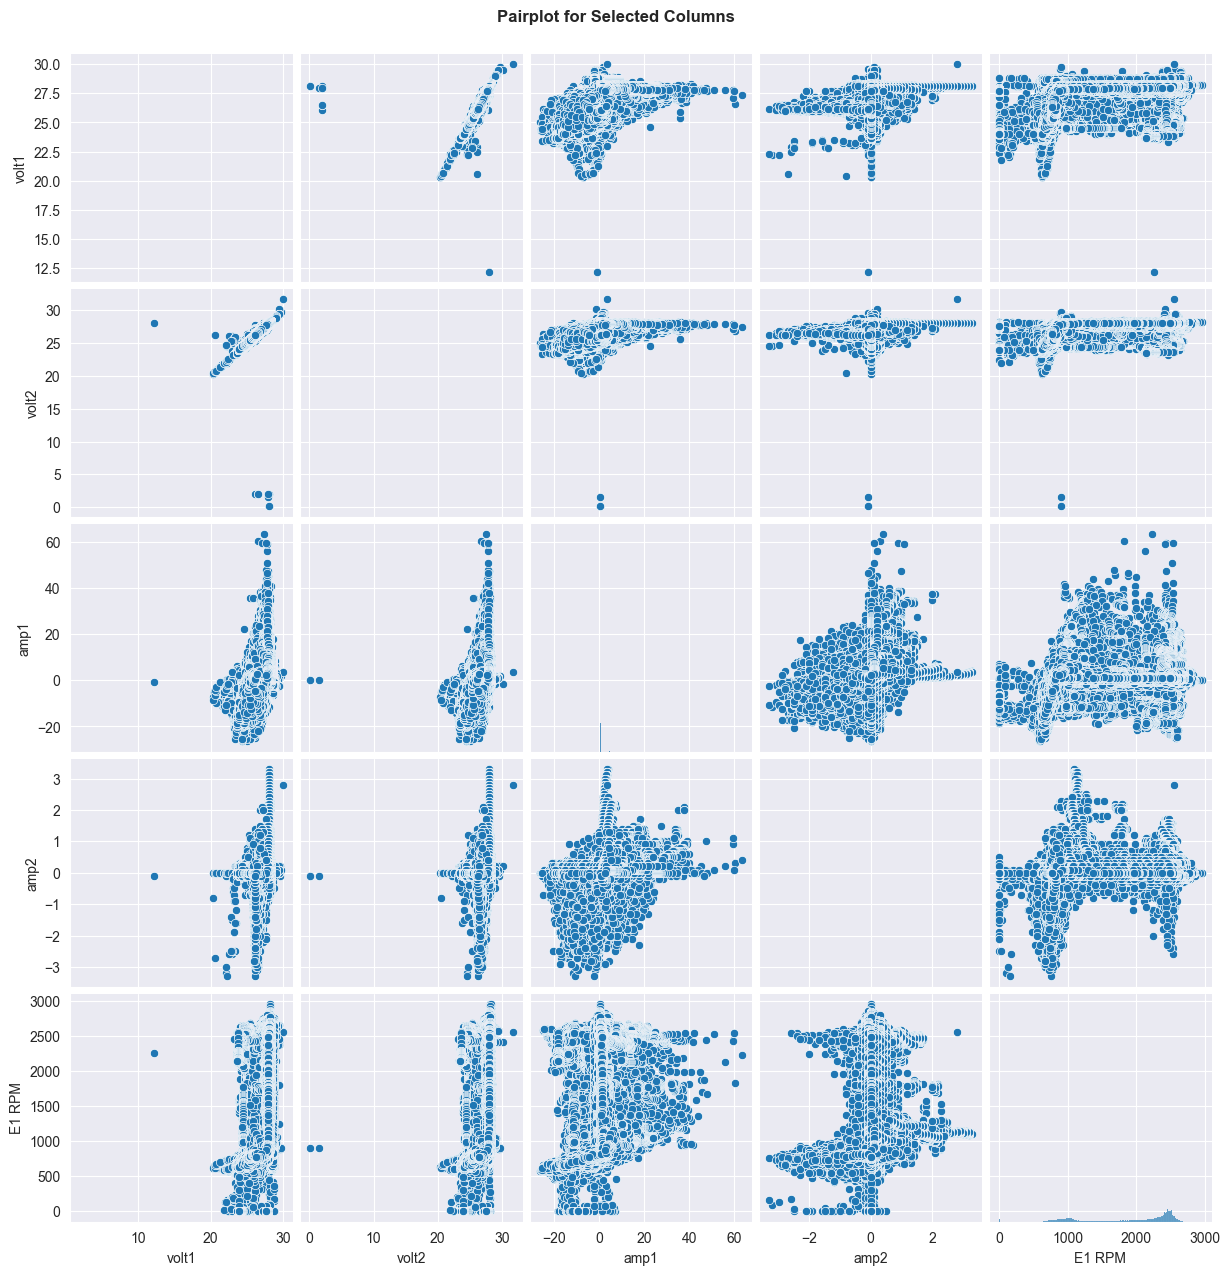

In [89]:
sns.pairplot(c37_df[['volt1', 'volt2', 'amp1', 'amp2', 'E1 RPM']])
plt.suptitle('Pairplot for Selected Columns', weight='bold', y=1.02)
plt.show()

**Observation:**

* **Strong Correlation**: volt1 and volt2 are highly correlated.
Potential Non-Linear Relationships: Some variables might have non-linear relationships.

* **Outliers**: Outliers are present and might indicate unusual conditions or errors.

* **Variable Distributions**: The distributions of variables vary, with some being more skewed than others.

**Violin Plot for E1 RPM Before and After Maintenance**
Visualizing E1 RPM in a Violin Plot for identifying if there is a distinct change in the values after a particular event (maintenance).

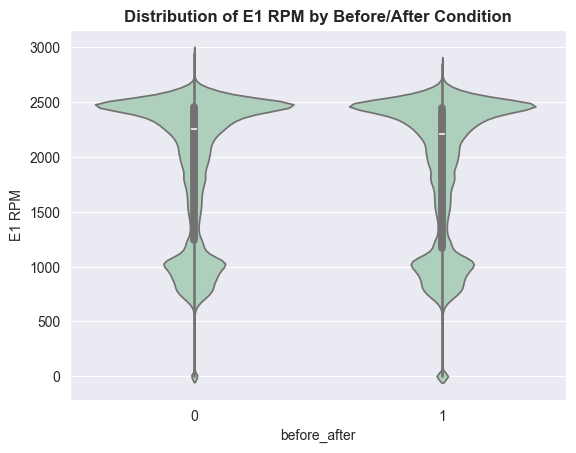

In [93]:
# Violin plot for a specific numerical feature
sns.violinplot(x='before_after', y='E1 RPM', data=c37_df, color='#A8D5BA')
plt.title('Distribution of E1 RPM by Before/After Condition', weight='bold')
plt.show()

**Observation:**

* **Similar Distributions**: Both before and after distributions have a similar shape, suggesting that the overall distribution of E1 RPM hasn't changed dramatically.

**Scatter Plot with Linear Regression Line**
Visualizing volt1 and volt2 on a scatter plot to determine if there is an association along a distribution (slope).

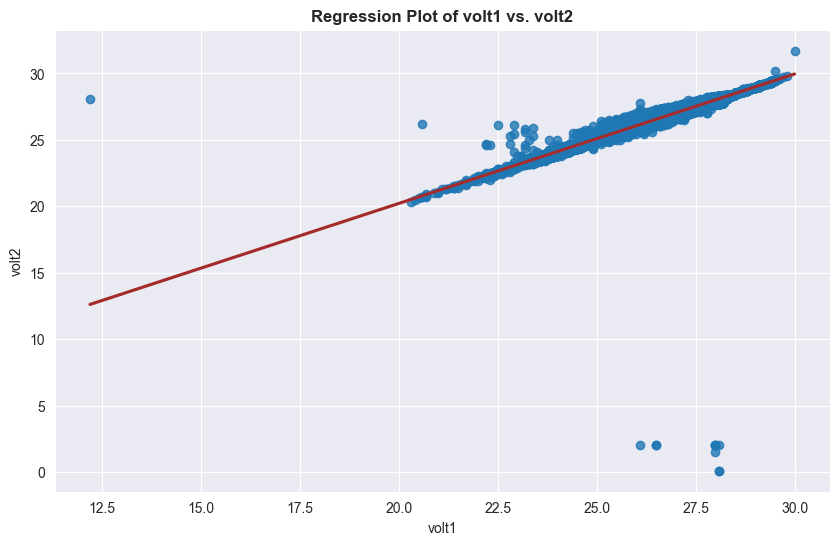

In [99]:
# Scatter plot with a linear regression line for volt1 and volt2
plt.figure(figsize=(10, 6))
sns.regplot(x='volt1', y='volt2', data=c37_df, scatter=True, line_kws={"color": "brown"})
plt.title('Regression Plot of volt1 vs. volt2', weight='bold')
plt.xlabel('volt1')
plt.ylabel('volt2')
plt.show()

**Observation:**

* **Strong Positive Correlation**: There's a very strong positive linear relationship between volt1 and volt2.

* **Tight Clustering**: Data points are tightly clustered around the regression line, indicating a high degree of association.

* **Minimal Scatter**: The scatter of points around the line is relatively low, suggesting that the model fits the data well.

**Heatmap Plots**
Visualizing numerical columns in a correlation matrix to identify which features are correlated.

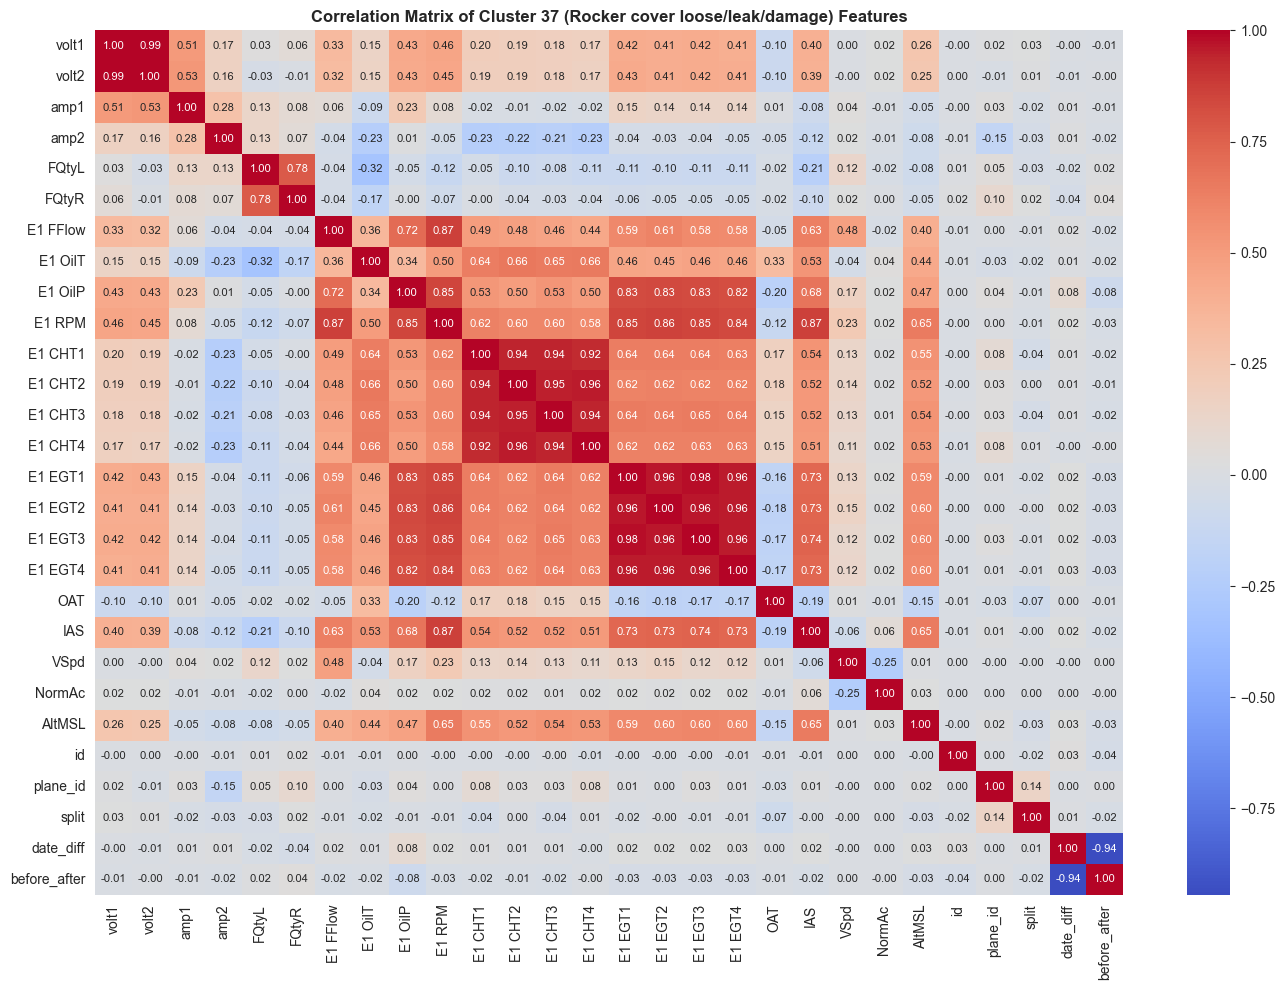

In [15]:
# Select only numeric columns for the correlation matrix
numeric_data = c37_df.select_dtypes(include=['float64', 'int64'])

# Plot: Correlation Matrix for relevant features
plt.figure(figsize=(14, 10))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Cluster 37 (Rocker cover loose/leak/damage) Features', weight='bold')
plt.tight_layout()
plt.show()

In [17]:
# Get list of most correlated features
# Set the threshold value
threshold = 0.2

# Get the column pairs with correlation greater than the threshold
high_corr_pairs = correlation_matrix.abs() > threshold

# Get the column names
high_corr_features = set()
for col in high_corr_pairs.columns:
    for index, value in high_corr_pairs[col].items():
        if value and col != index:
            high_corr_features.add(col)
            high_corr_features.add(index)

high_corr_features = list(high_corr_features)

# Print the correlated features
print(high_corr_features)

['E1 OilP', 'date_diff', 'E1 EGT3', 'FQtyR', 'amp2', 'volt2', 'amp1', 'IAS', 'E1 OilT', 'E1 RPM', 'E1 CHT2', 'E1 EGT2', 'E1 EGT4', 'VSpd', 'OAT', 'E1 FFlow', 'E1 CHT1', 'before_after', 'NormAc', 'volt1', 'E1 CHT4', 'E1 CHT3', 'FQtyL', 'AltMSL', 'E1 EGT1']


In [23]:
print(f'{len(high_corr_features)} of {c37_n_cols} features have correlation: -{threshold} ≥ x ≥ {threshold}.')

25 of 28 features have correlation: -0.2 ≥ x ≥ 0.2.


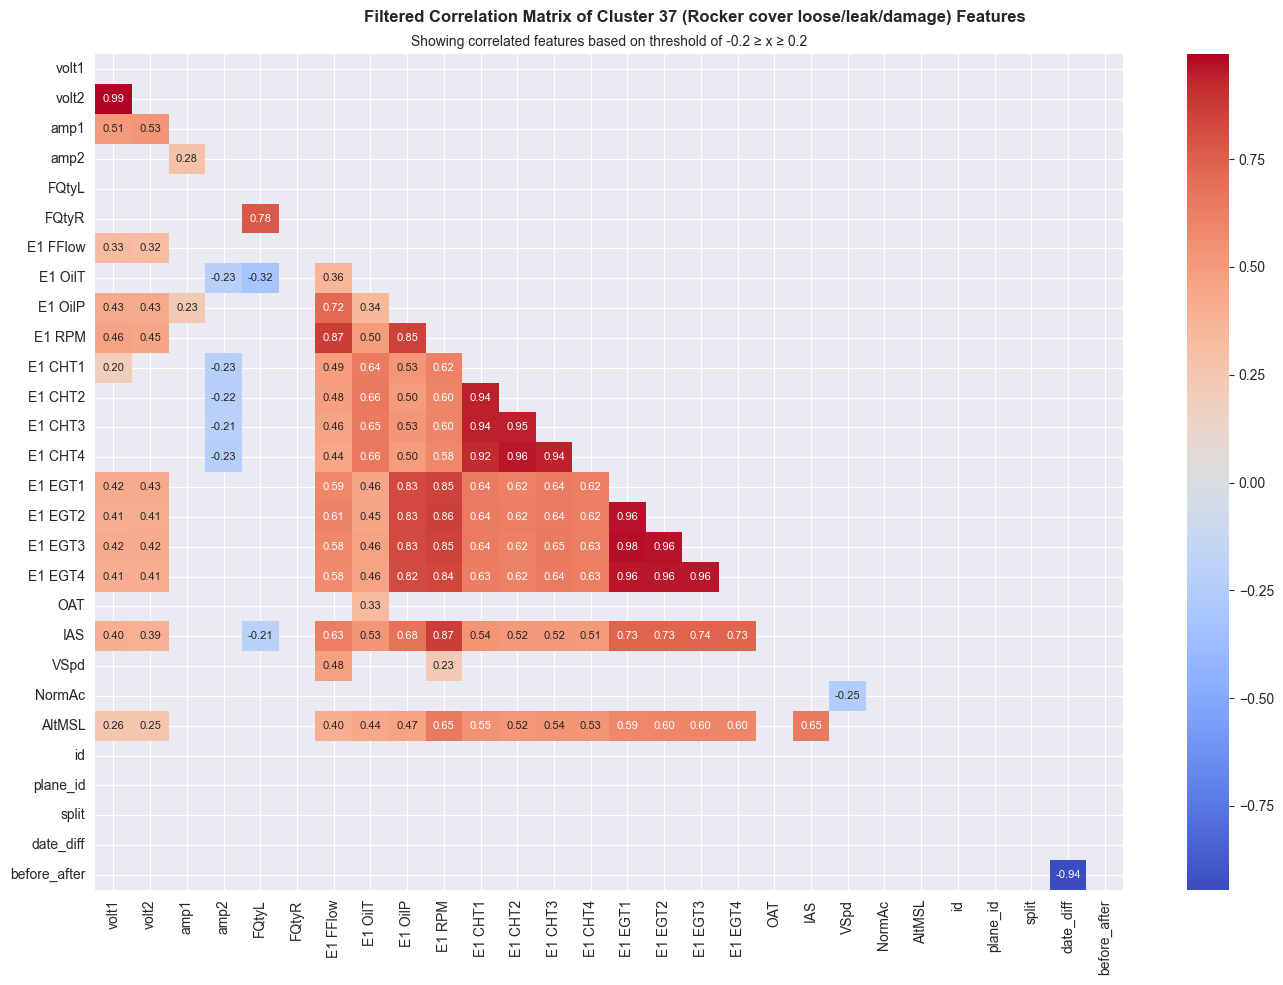

In [25]:
# Visualize highest correlated features only
fig, ax = plt.subplots(figsize=(14, 10))

# Create a mask to hide the upper triangle of the correlation matrix
trimask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=trimask | (np.abs(correlation_matrix) <= threshold), annot=True, annot_kws={"size": 8}, cmap='coolwarm', fmt=".2f", ax=ax)
plt.suptitle('Filtered Correlation Matrix of Cluster 37 (Rocker cover loose/leak/damage) Features', weight='bold')
ax.set_title(f'Showing correlated features based on threshold of -{threshold} ≥ x ≥ {threshold}', fontsize=10)
plt.tight_layout()
plt.show()

**Observation:** Applied a filter to the correlation heatmap by taking the absolute value and determining if it is greater than `0.2`. This created a mask that removed a lot of noice in the heatmap plot.

The key takeaways from the correlation matrix heatmap are as follows:
* Engine related sensors such prefixed with `E1` are the most positively correlated (typically greater than `0.5`)
* Features such as indicated air speed (`IAS`) and MSL altitude (`AltMSL`) also have a high positive linear correlation with engine related sensors prefixed with `E1`. This indicates that as indicated air speed and MSL altitude increases/decreases, engine oil temperature, engine RPM, engine fuel flow rate, etc., increases/decreases.

Additional analysis of the highly correlated features is as follows:

**Positive Correlations:**
* `vol1` and `volt2` at `0.99`: Nearly perfect linear correlation, indicating that the values might be nearly identical through. It is likely that dropping one of these features will have little impact on the total variance represented by the remaining features.
* `amp1` and `volt1` + `vol2` at `0.51` and `0.53` respectively: Strong positive linear correlation, indicating that as the amps on the main battery increase/decrease, the voltage of the main electrical system bus and essential bus also increase/decrease.
* `FQtyR` and `FQtyL` at `0.78`: Very high positive correlation between right and left fule quantity sensors, indicating that when right fule quantity reading increases/decreases, the left fule quantity reading also increases/decreases.
* `E1 FFlow` and `volt1` + `vol2` at `0.33` and `0.32` respectively: Moderately positive linear correlation, indicating that increases/decreases to engline fuel flow rate causes increases/decreases to main electrical system bus voltage and essential bus voltage.

**Negative Correlations:**
* `E1 OilT` and `amp2` + `FQtyL` at `-0.23` and `-0.32` respectively: Moderately negative linear correlation indicating that as the engine oil temperature increases/decreases, the standby battery amps and left fuel quantity decreases/increases.
* `amp2` and `E1 CHT1`, `E1 CHT2`, `E1 CHT3`, and `E1 CHT4` at `-0.23`, `-0.22`, `-0.21`, and `-0.23` respectively: Moderately negative linear correlation indicating that the standby battery amps increases/decreases as the 1st, 2nd, 3rd, and 4th cylinder head temperature decreases/increases.
* `IAS` and `FQtyL` at `-0.21`: Moderately negative linear correlation, indicating that as the indicated air speed increases/decreases, the fuel quantity (left) decreases/increases.
* `NormAc` and `VSpd` at `-0.25`: Moderately negative linear correlation, indicating that as normal acceleration increases/decreases, vertical speed decreases/increases.